In [1]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import
from sklearn.model_selection import train_test_split
from random import randint
import sklearn.metrics as skm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [2]:
def replace_rare_entries(df, columns, threshold_frac):
    tot_instances = df.shape[0]
    threshold = tot_instances * threshold_frac
    df = df.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in columns else x)
    return df
    

In [3]:
categoricals = ['OP_UNIQUE_CARRIER', 'DEST', 'DEP_TIME_BLK', 'DAY_OF_YEAR', 'DAY_OF_WEEK']
targets = ['DEP_DELAY_NEW', 'DEP_DEL15']

In [4]:
df = pd.read_csv('/home/dbeiski/Project/FlightDelay/Data/new_york/year_lga_dep.csv')

In [5]:
data = df.drop([col for col in df.columns if col not in categoricals], axis=1)
data = replace_rare_entries(data, ['DEST'], 0.005)
data = replace_rare_entries(data, ['UNIQUE_CARRIER'], 0.005)
data = pd.get_dummies(data, columns=categoricals)
label = df['DEP_DEL15']

In [6]:
data.columns

Index(['OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_B6',
       'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
       'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OH',
       'OP_UNIQUE_CARRIER_OO',
       ...
       'DAY_OF_YEAR_9_7', 'DAY_OF_YEAR_9_8', 'DAY_OF_YEAR_9_9',
       'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'],
      dtype='object', length=457)

In [7]:
data = data[~label.isna()]
label = label[~label.isna()]

In [8]:
print('Rows: {}\nFeatures: {}\nLabel-1 Fraction: {}'
      .format(data.shape[0], data.shape[1], label.sum() / label.shape[0]))

Rows: 181088
Features: 457
Label-1 Fraction: 0.21473537727513695


In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2,
                                                        random_state=randint(1, 500),
                                                        stratify=label)
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
arg = (y_test, xgbc.predict(x_test))
print('Accuracy: {}\nRecall: {}\nPrecision: {}\nf1_Score: {}'.format(skm.accuracy_score(*arg), skm.recall_score(*arg), skm.precision_score(*arg), skm.f1_score(*arg)))

Accuracy: 0.7943011762107239
Recall: 0.049376366208049374
Precision: 0.8707482993197279
f1_Score: 0.09345339498661474


In [11]:
probas = xgbc.predict_proba(x_test)[:, 1]

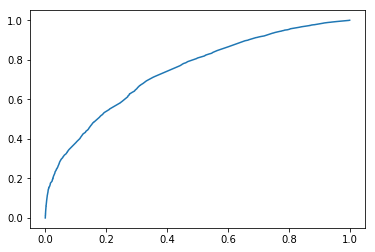

In [12]:
tpr, fpr, thres = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [13]:
thres = np.linspace(0, 1, 500)

In [14]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


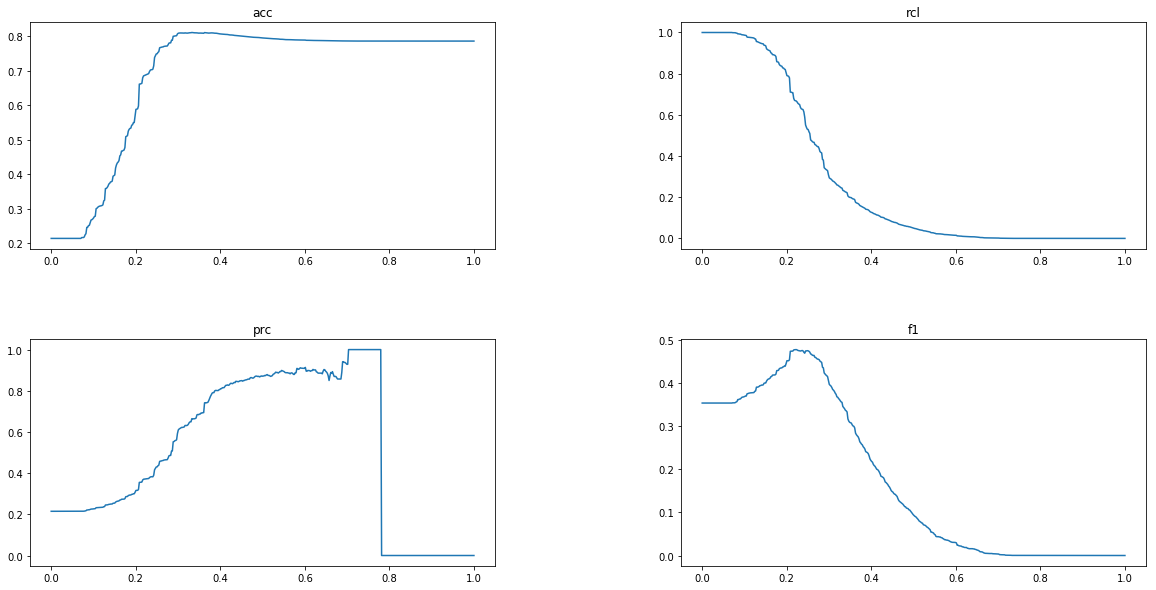

In [15]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4) 
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


In [16]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print(skm.accuracy_score(y_test, y_pred))

0.6864266386879452


In [17]:
best_thres

0.2224448897795591

In [22]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=y)
Dtrain = xgb.DMatrix(x_train, label=y_train)
Dval = xgb.DMatrix(x_val, label=y_val)

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [29]:
y_train.shape[0]

115896

In [88]:
param = {                              # General guidelines for initial paramaters:
    'min_child_weight': 1,             # 1 (choose small for high class imbalance)
    'gamma': 0.3,                        # 0.1-0.2
    'lambda': 0,  #1                     # L2 Regulariztion - default = 1
    'scale_pos_weight': 4,             # 1 (choose small for high class imbalance)
    'subsample': 0.6,                    # 0.5-0.9
    'colsample_bytree': 0.8,             # 0.5-0.9
    'colsample_bylevel': 0.7,              # 0.5-0.9
    'max_depth': 6,  #5                  # 3-10 
    'eta': 0.1,                        # 0.05-0.3
    'silent': 0,                       # 0 - prints progress    1 - quiet
    'objective': 'binary:logistic',        
    'num_class': 1,             
    'eval_metric': 'auc'}  
num_round = 10000                                      # the number of training iterations if not stopped early
evallist = [(Dtrain, 'train'), (Dval, 'eval')]        # Specify validation set to watch performance

In [89]:
# Train the model on the training set to get an initial impression on the performance
model = xgb.train(param, Dtrain, num_round, evallist, early_stopping_rounds=10)
print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-auc:0.61395	eval-auc:0.613115
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.650994	eval-auc:0.649883
[2]	train-auc:0.677675	eval-auc:0.677338
[3]	train-auc:0.677007	eval-auc:0.677186
[4]	train-auc:0.678449	eval-auc:0.678397
[5]	train-auc:0.679048	eval-auc:0.678823
[6]	train-auc:0.685003	eval-auc:0.684452
[7]	train-auc:0.689062	eval-auc:0.687981
[8]	train-auc:0.694032	eval-auc:0.69224
[9]	train-auc:0.69542	eval-auc:0.693524
[10]	train-auc:0.695059	eval-auc:0.692796
[11]	train-auc:0.699041	eval-auc:0.696448
[12]	train-auc:0.699923	eval-auc:0.696225
[13]	train-auc:0.705036	eval-auc:0.701456
[14]	train-auc:0.706708	eval-auc:0.702012
[15]	train-auc:0.709655	eval-auc:0.704865
[16]	train-auc:0.713615	eval-auc:0.708301
[17]	train-auc:0.714589	eval-auc:0.70975
[18]	train-auc:0.715322	eval-auc:0.710653
[19]	train-auc:0.716542	eval-auc:0.711727
[20]	train-auc:0.717496	eval-auc:

[192]	train-auc:0.800881	eval-auc:0.784078
[193]	train-auc:0.80088	eval-auc:0.784047
[194]	train-auc:0.801168	eval-auc:0.784309
[195]	train-auc:0.801341	eval-auc:0.784377
[196]	train-auc:0.80157	eval-auc:0.784595
[197]	train-auc:0.801679	eval-auc:0.784713
[198]	train-auc:0.801892	eval-auc:0.784955
[199]	train-auc:0.802004	eval-auc:0.785021
[200]	train-auc:0.802214	eval-auc:0.785135
[201]	train-auc:0.802413	eval-auc:0.785276
[202]	train-auc:0.80264	eval-auc:0.785438
[203]	train-auc:0.802961	eval-auc:0.785643
[204]	train-auc:0.803011	eval-auc:0.78566
[205]	train-auc:0.803378	eval-auc:0.786083
[206]	train-auc:0.80366	eval-auc:0.786178
[207]	train-auc:0.803804	eval-auc:0.786288
[208]	train-auc:0.803938	eval-auc:0.786294
[209]	train-auc:0.804084	eval-auc:0.78646
[210]	train-auc:0.804276	eval-auc:0.786659
[211]	train-auc:0.804492	eval-auc:0.786663
[212]	train-auc:0.804621	eval-auc:0.786756
[213]	train-auc:0.804959	eval-auc:0.786981
[214]	train-auc:0.805052	eval-auc:0.786998
[215]	train-auc:0

[384]	train-auc:0.825216	eval-auc:0.796733
[385]	train-auc:0.82528	eval-auc:0.796744
[386]	train-auc:0.825341	eval-auc:0.79672
[387]	train-auc:0.825439	eval-auc:0.796809
[388]	train-auc:0.825516	eval-auc:0.796876
[389]	train-auc:0.825664	eval-auc:0.796929
[390]	train-auc:0.825752	eval-auc:0.796858
[391]	train-auc:0.825794	eval-auc:0.796838
[392]	train-auc:0.825954	eval-auc:0.796886
[393]	train-auc:0.826014	eval-auc:0.796922
[394]	train-auc:0.826105	eval-auc:0.79697
[395]	train-auc:0.826235	eval-auc:0.797055
[396]	train-auc:0.826334	eval-auc:0.797053
[397]	train-auc:0.826433	eval-auc:0.797084
[398]	train-auc:0.826585	eval-auc:0.797069
[399]	train-auc:0.826628	eval-auc:0.797085
[400]	train-auc:0.826646	eval-auc:0.797092
[401]	train-auc:0.826749	eval-auc:0.797049
[402]	train-auc:0.826797	eval-auc:0.797065
[403]	train-auc:0.826862	eval-auc:0.79707
[404]	train-auc:0.826922	eval-auc:0.797048
[405]	train-auc:0.827035	eval-auc:0.797099
[406]	train-auc:0.827132	eval-auc:0.797185
[407]	train-auc

In [93]:
Dtest = xgb.DMatrix(x_test, label=y_test)
probas = model.predict(Dtest)
y_test = Dtest.get_label()

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


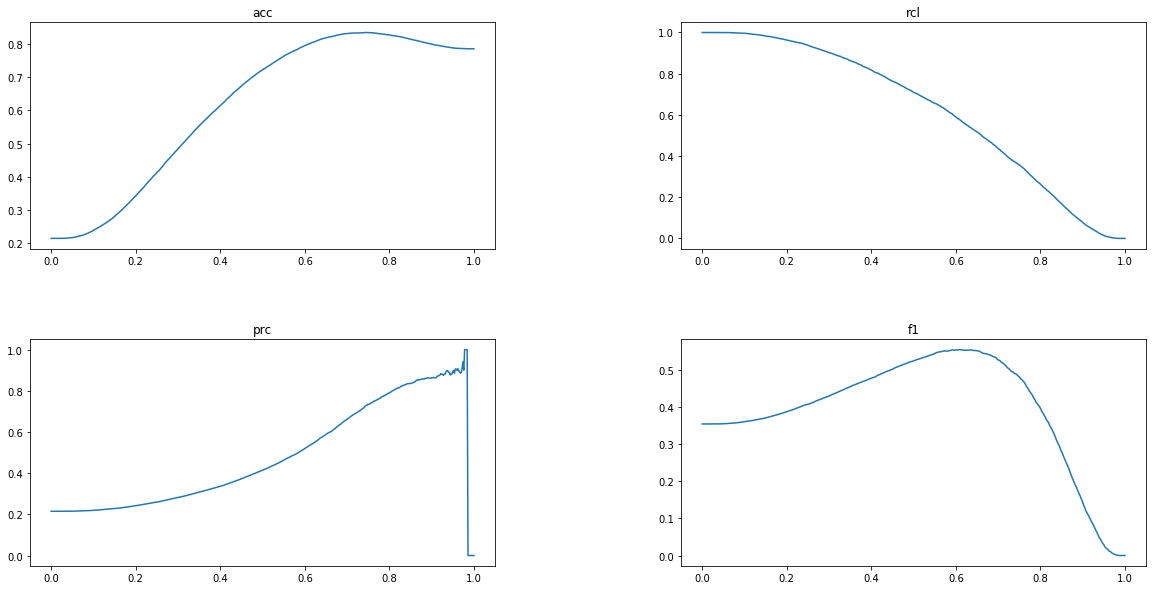

In [94]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


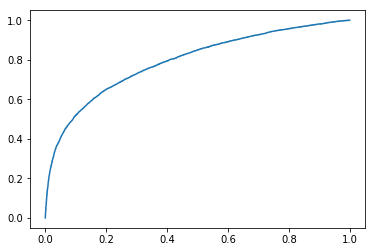

In [95]:
tpr, fpr, _ = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [98]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print('Acc for max f1 threshold: ', skm.accuracy_score(y_test, y_pred))
print('Max acc : ', max(accs))

Acc for max f1 threshold:  0.800182229830471
Max acc :  0.8343365177536032


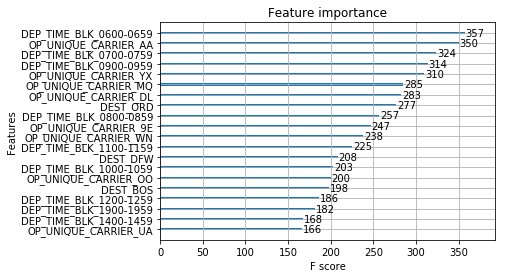

In [97]:
xgb.plot_importance(model, max_num_features=20);